In [118]:
import gym
import numpy as np
import torch
import torch.nn as nn
import cma
import gym
from gym import spaces
from utils import count_parameters

class Plane(gym.Env):
    def __init__(self):
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,))
        self.observation_space = spaces.Box(low=-10.0, high=10.0, shape=(2,))
        self.current_position = None
        self.target_position = None
        self.max_steps = 500
        self.current_step = None
        self.dt = 0.01

    def reset(self):
        self.current_position = np.random.uniform(low=-10.0, high=10.0, size=(2,))
        self.target_position = [1., 2.]
        self.current_step = 0
        return self.current_position

    def step(self, action):
        # print(action)
        self.current_position += action.detach().numpy() * self.dt
        distance = np.linalg.norm(self.current_position - self.target_position)
        reward = -distance
        done = distance < 1e-5 or self.current_step == self.max_steps
        self.current_step += 1
        return self.current_position, reward, done, {}

    def render(self, mode='human'):
        pass

class simplest_andps(nn.Module):
    def __init__(self, ds_dim):
        super(simplest_andps, self).__init__()
        self.ds_dim = ds_dim
        self.x_tar= nn.Parameter(torch.randn(self.ds_dim))

    def forward(self, x):
        # print(self.x_tar)
        # print(x)
        return torch.eye(self.ds_dim) @ (self.x_tar - x)

def evaluate(model_params, env):
    # print(model_params)
    global policy
    policy = simplest_andps(env.observation_space.shape[0])
    model_dict = policy.state_dict()
    # print(model_dict.keys())
    model_dict['x_tar'] = torch.Tensor(model_params)
    policy.load_state_dict(model_dict)
    total_reward = 0
    obs = env.reset()
    done = False
    while not done:
        velocity = policy(torch.from_numpy(obs).float())
        # velocity = np.eye(2) * (target - obs)
        obs, reward, done, info = env.step(velocity)
        total_reward += reward
    return -total_reward


In [119]:

env_name = 'Plane-v0'
env = Plane()
# model_parameters = filter(lambda p: p.requires_grad, simplest_andps(2).parameters())
# num_params = sum([np.prod(p.size()) for p in model_parameters])

num_params = count_parameters(simplest_andps(2))
#
# num_params = sum(p.numel() for p in simplest_andps(env.observation_space.shape[0]).parameters())
es = cma.CMAEvolutionStrategy(np.zeros(num_params),1)


(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1053841, Mon Mar 27 17:50:24 2023)


In [120]:
while not es.stop():
    solutions = es.ask()
    fitness_list = []
    for s in solutions:
        fitness_list.append(evaluate(s, env))
    # print(solutions)
    es.tell(solutions, fitness_list)
    es.logger.add()

In [121]:
print(policy.x_tar)


Parameter containing:
tensor([1.8823, 2.0098], requires_grad=True)


In [122]:
%matplotlib inline

In [123]:
dict(es.result._asdict())  

{'xbest': array([0.75542694, 1.96552641]),
 'fbest': 155.01552554014023,
 'evals_best': 144,
 'evaluations': 3030,
 'iterations': 505,
 'xfavorite': array([1.88225001, 2.00977316]),
 'stds': array([9.20680920e-09, 1.42173593e-08]),
 'stop': {'tolstagnation': 146}}

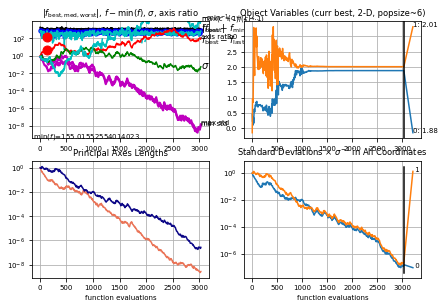

In [124]:
es.plot()

In [134]:
import matplotlib.pyplot as plt
def eval_andps():

    cur_pos = np.random.uniform(low=-10.0, high=10.0, size=(2,))
    trajectory = np.array(cur_pos)
    while True:
        action = policy(torch.Tensor(cur_pos)).detach().numpy()
        # print(action)
        cur_pos = action * 0.01
        print(cur_pos)
        trajectory = np.vstack([trajectory, cur_pos])
        if(np.linalg.norm(cur_pos-np.array([1.,2.]))<1e-2):
            break
    
    plt.plot(trajectory[0,:], trajectory[1,:])

In [135]:
eval_andps()